# CitiBike 
## Data Cleaning, Imputing Missing Trips, and Identifying Broken Bikes
The Citi Bike system is a bicycle ride sharing system based in New York City where users can rent bikes for short periods of time. Users pick up a bike at a station, and ride to another station where they drop the bike off. The bikes are used for commuting, sight seeing, and general travelling throughout the city.

During high traffic times it can be difficult to determine if a Citi Bike will be available at a given station at a given time in the future. This could be especially useful for commuters to determine when they should leave for work or leave from work to ensure a Citi Bike is available.

<img src="citi_bike_rad_dude.jpg" width=600 height=400 />

The goal of this project is to develop a predictive model to enable Citi Bike users to determine the probability of a Citi Bike being available at somepoint in the future. This is based on the Citi Bike trips data set, as well as Citi Bike Stations Live feed. The trips data set contains information on a trip level, with a start and stop destination as well as some basic information regarding the user. The Station Live Feed contains information on stations, such as the total docks available at a given station.

This notebook can be separated into the following parts:
- Initial data importing and cleaning

- Identifying missing trips, and imputing/simulating the missing trips

- Developing a statistical model to identify broken bikes and simulate removal


In [138]:
import pandas as pd
import numpy as np
import os
import stat
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt

### Read Trips Data

I start by importing the May 2020 trips dataset.

In [139]:
folder = os.getcwd()
zip_file = '/202005-citibike-tripdata.csv.zip'
zip_file_path = folder + zip_file

In [6]:
# Read compressed csv files
trips = pd.read_csv(zip_file_path, compression='zip')

# Replace all spaces with underscores in column names
trips.columns = [x.replace(' ', '_') for x in trips.columns]

# Round start and stop times to nearest second
trips['starttime'] = pd.to_datetime(trips.starttime).dt.floor('s')
trips['stoptime'] = pd.to_datetime(trips.stoptime).dt.floor('s')

In [7]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487890 entries, 0 to 1487889
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   tripduration             1487890 non-null  int64         
 1   starttime                1487890 non-null  datetime64[ns]
 2   stoptime                 1487890 non-null  datetime64[ns]
 3   start_station_id         1487890 non-null  int64         
 4   start_station_name       1487890 non-null  object        
 5   start_station_latitude   1487890 non-null  float64       
 6   start_station_longitude  1487890 non-null  float64       
 7   end_station_id           1487890 non-null  int64         
 8   end_station_name         1487890 non-null  object        
 9   end_station_latitude     1487890 non-null  float64       
 10  end_station_longitude    1487890 non-null  float64       
 11  bikeid                   1487890 non-null  int64         
 12  

In [8]:
print('Start Date: ' + str(min(trips.starttime)))
print('End Date: ' + str(max(trips.starttime)))
print('Number of unique starting stations: ' + str(len(set(trips['start_station_name']))))

Start Date: 2020-05-01 00:01:06
End Date: 2020-05-31 23:59:48
Number of unique starting stations: 923


The trips data set for the month of May 2020 has 1.49 million records of trips, with 923 unique starting stations.

### Request station information from API
The station live feed is requested from the web URL.

<img src="citi_bike_station.jpg" width=800/>

In [250]:
# Request Citi Bike Station Feed Data from API
station_feed_url = 'https://feeds.citibikenyc.com/stations/stations.json'
req = requests.get(station_feed_url)

# Convert results into Pandas Dataframe
stations = pd.DataFrame.from_dict(req.json())
stations = stations.stationBeanList.apply(pd.Series)
#stations.to_csv(folder + '/station_feed_' + dt.datetime.now().strftime('%m-%d-%y') + '.csv')
#stations = pd.read_csv(folder + '/station_feed_' + dt.datetime.now().strftime('%m-%d-%y') + '.csv')

In [251]:
print('Earliest Communication Time: ' + str(min(stations.lastCommunicationTime)))
print('Latest Communication Time: ' + str(max(stations.lastCommunicationTime)))

Earliest Communication Time: 2020-05-12 07:39:49 AM
Latest Communication Time: 2020-05-30 12:04:50 AM


In [252]:
# Find which stations are in the trips and station feed data sets
trips_stations = set(pd.concat([trips.start_station_id, trips.end_station_id]))
feed_stations = set(stations.id)

#Identify missing stations in the station feed data set
missing_stations = [station for station in trips_stations if station not in feed_stations]

print(len(missing_stations))
print(len(trips_stations))

2
934


The stations feed data table contains information for 932 out of 934 unique stations. The two stations which are not included in the reference table are shown below. The "NYCBS DEPOT" is the NYC Bike Share Depot.

In [319]:
trips[trips.start_station_id.isin(missing_stations)].drop_duplicates(subset='start_station_name')['start_station_name']

14272    Stuyvesant Walk & 1 Av Loop
Name: start_station_name, dtype: object

In [320]:
trips[trips.end_station_id.isin(missing_stations)].drop_duplicates(subset='end_station_name')['end_station_name']

20295     Stuyvesant Walk & 1 Av Loop
882506         NYCBS DEPOT - DELANCEY
Name: end_station_name, dtype: object

### Stack trips data into Operations dataframe with arrivals and departures
For easier processing, it is better to treat starts and stops as two different operations records. This next section transforms the data into this format.

We define a column based on if the operation is an arrival or departure. Another column "net_bikes" is 1 if a bike arrives at a station and -1 if a bike leaves the station. This will be used to track the number of bikes at a given station.

In [33]:
trips = trips.rename(columns={'tripduration': 'trip_duration', 
                              'starttime': 'start_time',
                              'stoptime': 'stop_time',
                              'bikeid': 'bike_id',
                              'usertype': 'user_type'})

starts = trips[['start_time', 'start_station_id', 'start_station_name', 'bike_id']]
stops = trips[['stop_time', 'end_station_id', 'end_station_name', 'bike_id']]

starts = starts.rename(columns={'start_time': 'op_time', 'start_station_id': 'station_id', 'start_station_name': 'station_name'})
stops = stops.rename(columns={'stop_time': 'op_time', 'end_station_id': 'station_id', 'end_station_name': 'station_name'})

starts['op_type'] = 'departure'
stops['op_type'] = 'arrival'

starts['net_bikes'] = -1
stops['net_bikes'] = 1

ops = pd.concat([starts, stops]).sort_values(by='op_time')

### Determine available bikes
Determining the number of available bikes at any given time is a challenge since the number of available bikes is not recorded in the trips data. It is only recorded in the stations data, which is based on a single time point in the month. However, since we can track the movement of bikes, the amount of bikes available at any time during the month can be determined.

The first step is to add new entries into the ops dataframe when we receive station status updates, and include the number of available bikes at the time of transmission.

In [35]:
# Transform station updates data into ops data format
station_cols = ['lastCommunicationTime', 'id', 'stationName', 'availableBikes']
status_updates = stations[station_cols].rename(columns={'lastCommunicationTime': 'op_time', 
                                                        'id': 'station_id', 
                                                        'stationName': 'station_name',
                                                        'availableBikes': 'available_bikes'})

status_updates['op_time'] = pd.to_datetime(status_updates['op_time'])
status_updates['op_type'] = 'status'
status_updates['net_bikes'] = 0
status_updates['bike_id'] = np.nan

# Merge status updates
ops = pd.concat([ops, status_updates]).sort_values(by='op_time')

# Calculate the net change in bikes since the start of the month (not knowing how many bikes were available to start)
ops['sum_net_bikes'] = ops.groupby('station_id')['net_bikes'].cumsum()

# Create offset table with the number of bikes available at the start of the month at each station
offset = ops[ops.op_type=='status'][['station_id', 'available_bikes', 'sum_net_bikes']].copy()
offset['starting_bikes'] = offset['available_bikes'] - offset['sum_net_bikes']

The number of starting bikes should always be greater than 0 and less than the number of total docks available. However this doesn't hold true. This means that some operations are missing from the data.

There are three reasons this could be;
- Missing trip information
- Redistribution of bikes from some location to another by Citi Bike 
- Broken bikes being removed from a station

The opposite could occur;
- New bikes being introduced to the system at a given station

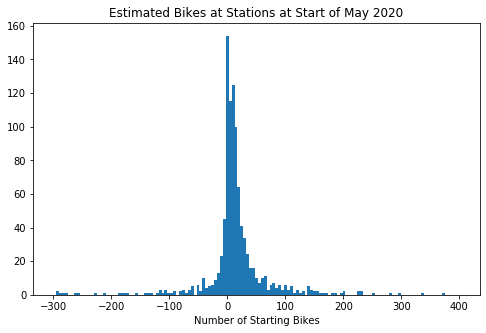

In [265]:
plt.rcParams['figure.figsize'] = 8, 5
plt.hist(offset.starting_bikes, bins=np.linspace(-300, 400, 140))
plt.xlabel('Number of Starting Bikes')
plt.title('Estimated Bikes at Stations at Start of May 2020')
plt.show()

One key piece of information available is we have the bike id. This means we can track bikes across the system. We can look for times a bike was dropped off at a station and "magically" was checked out at a different station could provide an estimate of how prevelant this is. While this won't tell us how the bike "magically" moved locations, it would tell us how frequently this occurs. In addition, we could then augment our trip data and create trip information which moves the bike from one location to the next. This would likely improve our understanding how frequently a bike is moved.

In [267]:
trips['prev_end_station_id'] = trips.sort_values(by='start_time').groupby('bike_id')['end_station_id'].shift()
trips['prev_end_station_name'] = trips.sort_values(by='start_time').groupby('bike_id')['end_station_name'].shift()
trips['prev_stop_time'] = trips.sort_values(by='start_time').groupby('bike_id')['stop_time'].shift()

trips['station_match'] = trips.start_station_id == trips.prev_end_station_id

print('Percent of trips which connect %.2f' % (100*np.mean(trips[~trips.prev_end_station_id.isna()]['station_match'])))

Percent of trips which connect 98.34


98.34 % of bike trips start at the previous trip's end location. This is fairly good, and I believe that by adding the missing "trip" information, we can reach a better estimate of the number of bikes at a given location.

### Impute Missing Trips

The most unknown part of creating the new trip would be the time the bike left the previous station and arrived at the next station. I will choose to pick the midpoint between the previous arrival and the current departure time, with an instaneous travel time.

In [273]:
missing = trips[(~trips.prev_end_station_id.isna()) & (~trips.station_match)].copy()
missing['time_gap'] = missing.start_time - missing.prev_stop_time
missing['missing_op_time'] = (missing.prev_stop_time + missing.time_gap/2).dt.floor('s')

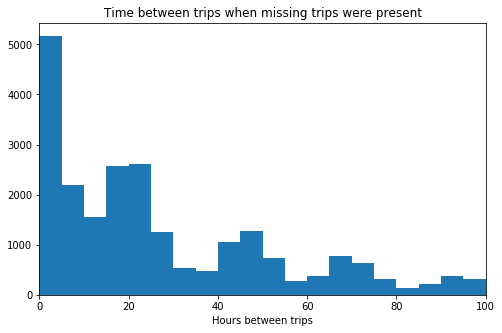

In [277]:
plt.hist(missing.time_gap.dt.total_seconds() / 3600, bins=np.linspace(0, 100, 21))
plt.xlim([0, 100])
plt.xlabel('Hours between trips')
plt.title('Time between trips when missing trips were present')
plt.show()

In [43]:
# Create dataframe of simulated data
sim_starts = missing[['missing_op_time', 'prev_end_station_id', 'prev_end_station_name', 'bike_id']]
sim_stops = missing[['missing_op_time', 'start_station_id', 'start_station_name', 'bike_id']]

sim_starts = sim_starts.rename(columns={'missing_op_time': 'op_time', 'prev_end_station_id': 'station_id', 'prev_end_station_name': 'station_name'})
sim_stops = sim_stops.rename(columns={'missing_op_time': 'op_time', 'start_station_id': 'station_id', 'start_station_name': 'station_name'})

sim_starts['op_type'] = 'departure'
sim_stops['op_type'] = 'arrival'

sim_starts['net_bikes'] = -1
sim_stops['net_bikes'] = 1

sim_ops = pd.concat([sim_starts, sim_stops]).sort_values(by='op_time')

In [293]:
# Append simulated trips data to ops data and refer to new dataframe as ops_full
ops_full = pd.concat([sim_ops, ops]).sort_values(by='op_time')
ops_full['sum_net_bikes'] = ops_full.groupby('station_id')['net_bikes'].cumsum()

# Calculate the new number of starting bikes
offset_full = ops_full[ops_full.op_type=='status'][['station_id', 'available_bikes', 'sum_net_bikes']].copy()
offset_full['starting_bikes'] = offset_full['available_bikes'] - offset_full['sum_net_bikes']

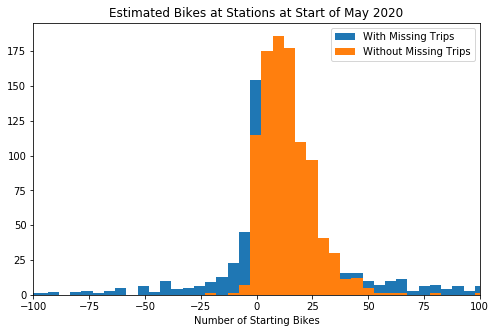

In [287]:
plt.rcParams['figure.figsize'] = 8, 5
plt.hist(offset.starting_bikes, bins=np.linspace(-300, 400, 140), label='With Missing Trips')
plt.hist(offset_full.starting_bikes, bins=np.linspace(-300, 400, 140), label='Without Missing Trips')
plt.xlabel('Number of Starting Bikes')
plt.title('Estimated Bikes at Stations at Start of May 2020')
plt.legend()
plt.xlim([-100, 100])
plt.show()

We can see that by augmenting missing trip data the starting offset data is within the expected range of between 0 - 50 bikes per station. More rigorously, we can merge the number of docks available at a station, and confirm that the number of starting bikes is within. Below is the distribution of the number of docks available at a station. Most docking stations have about 20-30 docks.

Text(0.5, 1.0, 'Citi Bike Station Sizes')

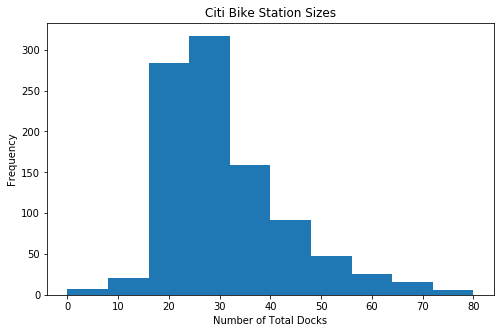

In [288]:
stations.totalDocks.plot.hist()
plt.xlabel('Number of Total Docks')
plt.title('Citi Bike Station Sizes')

The data shows some stations now have 0 total docks. Since the the total dock information is recorded at the end of the month it could be possible that these stations were closed. While we could remove these stations, it would be important to keep these stations as bikes might have been able to travel to them at some point in the month and this would break the continuity in bike routings established previously. 

In [294]:
# Merge the number of total docks
offset_full = offset_full.merge(stations[['id', 'totalDocks']], how='left', left_on='station_id', right_on='id')

# Get the percent of invalid starting bikes available
print('Percent of invalid starting bikes %.2f ' % (100*np.mean((offset_full.starting_bikes < 0) | (offset_full.starting_bikes > offset_full.totalDocks))))

Percent of invalid starting bikes 4.73 


The data shows that 4.73% stations do not fufill a valid starting criteria. This means that our data augmentation significantly improved our station data, but was not a complete solution. 

One possible solution for this could be bikes being removed from the system if they break. Since we would not have another trip after the bike was removed, the bike would remain assigned to the station. It would just appear that the bike has been sitting idle at a station for a long period of time. We could potentially solve this by adding simulated removals if a bike has been at a given station for a certain period of time. However, this would not be a perfect solution since it would be very possible for a bike to remain at a low traffic station for a long period of time.

<img src="service.jpg" width=900/>

A better solution would be to idenitfy broken bikes by modelling the selection of bikes at station. We could ask the question, what is the probability of this bike having not been selected after a certain number of customers have selected bikes from this location? This would assume that customers randomly select bikes from stations, which may not be exactly true. Customers may select bikes near the ends of the station at a higher frequency than the middle since customers usually approach the stations from the ends and they would likely pick bikes near the sides. However, we don't have information about where the bikes are docked within a given station.

One additional consideration that we need to make is that the probability of bike being selected is porportional to the number of other bikes at a station at given time. This will likely improve the accuracy of our model since there will be times with only a few bikes at a station. With only a few bikes, the probability of a bike being selected is higher, and thus there is greater signficance if the bike is not selected.



### Identify Broken Bikes
Define two classes, CitiBike and Station. These classes will track the use of bikes, most importantly the number of times a given bike has not been selected.

In [296]:
class CitiBike(object):
    def __init__(self, id, location, last_drop_off_time):
        self.id = id
        self.location = location
        self.prob_not_selected = 1
        self.consecutive_times_not_selected = 0
        self.last_drop_off_time = last_drop_off_time

    def bike_selected(self):
        self.prob_not_selected = 1
        self.location = 1
        self.consecutive_times_not_selected = 0

    def bike_drop_off(self, location, time):
        self.location = location
        self.last_drop_off_time = time
    
    def bike_not_selected(self, bikes_available):
        p = 1/bikes_available
        self.prob_not_selected = self.prob_not_selected*(1 - p)
        self.consecutive_times_not_selected += 1

In [297]:
class Station(object):
    def __init__(self, station_id, station_name, total_docks, bikes=[]):
        self.station_id = station_id
        self.station_name = station_name
        self.total_docks = total_docks
        self.bikes = bikes
    
    def add_bike(self, bike):
        self.bikes.append(bike)
    
    def remove_bike(self, bike):
        self.bikes.remove(bike)

In [298]:
unique_stations = ops_full.drop_duplicates(subset=['station_id'], keep='first')
all_stations = unique_stations[['station_id', 'station_name']].merge(stations[['id', 'totalDocks']], how='left', left_on='station_id', right_on='id').drop(columns={'id'})

In [301]:
# Initialize network and fleet dictionaries
def initialize_network_and_fleet(all_stations, ops_full):
    # Initialize Station objects for each station
    network = {}
    for i, row in all_stations.iterrows():
        network[row['station_id']] = Station(row['station_id'], row['station_name'], row['totalDocks'], [])

    # Add station for bikes to live in when they leave, called "City"
    network[-1] = Station(-1, 'City', 999999, [])

    # Initialize fleet based on starting location of first operation of each bike
    fleet = {}
    first_ops = ops_full[ops_full.op_type!='status'].drop_duplicates(subset=['bike_id'], keep='first')

    for bike_id, station_id, op_type, op_time in first_ops[['bike_id', 'station_id', 'op_type', 'op_time']].values:
        if op_type == 'departure':
            starting_location = station_id
            last_drop_off_time = np.nan
        else:
            starting_location = station_id
            last_drop_off_time = op_time
        fleet[bike_id] = CitiBike(bike_id, starting_location, last_drop_off_time)
        network[station_id].add_bike(bike_id)    

    return network, fleet

In [304]:
def run_simulation(ops_full, network, fleet):
    for bike_id, station_id, op_type, op_time in ops_full[['bike_id', 'station_id', 'op_type', 'op_time']].values:
        # Get CitiBike and Station objects
        bike = fleet[bike_id]
        station = network[station_id]

        # If departure, bike has been selected, and remove bike station
        if op_type == 'departure':
            num_bikes_available = len(station.bikes)
            bike.bike_selected()
            station.remove_bike(bike_id)

            # Increment selection probability of other bikes at this station
            for bike_id in station.bikes:
                fleet[bike_id].bike_not_selected(num_bikes_available)
        
        # If arrival, bike has been dropped of, and add bike to station
        elif op_type == 'arrival':
            bike.bike_drop_off(station_id, op_time)
            station.add_bike(bike_id)
    return network, fleet

In [305]:
ops_full = ops_full[~ops_full.bike_id.isna()].copy()
network, fleet = initialize_network_and_fleet(all_stations, ops_full)
network, fleet = run_simulation(ops_full, network, fleet)

In [306]:
len(ops_full)

3024690

The combination of transforming the data into a numpy array and the class based structure means this analysis runs very fast - it will process over 3 million operations in less than 60 seconds!

Get summary information of the probability of each bike not being selcted at the end of May 2020.

In [308]:
bike_summ = pd.DataFrame([bike.__dict__ for bike in fleet.values()])

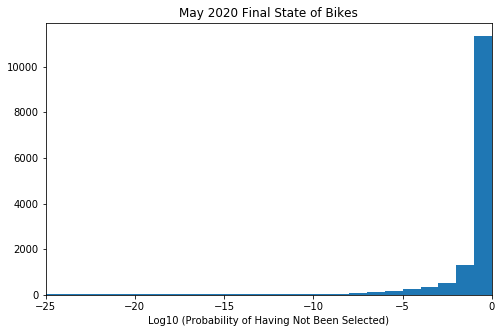

In [309]:
plt.hist(np.log10(bike_summ.prob_not_selected), bins=np.linspace(-200, 0, 201))
plt.xlim([-25, 0])
plt.xlabel('Log10 (Probability of Having Not Been Selected)')
plt.title('May 2020 Final State of Bikes')
plt.show()

Text(0, 0.5, 'Log P(Bike Having Not Been Selected)')

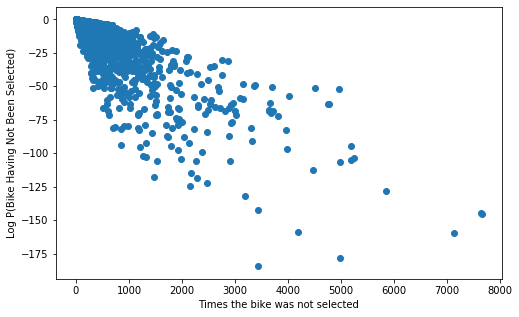

In [310]:
plt.plot(bike_summ.consecutive_times_not_selected, np.log10(bike_df.prob_not_selected), 'o')
plt.xlabel('Times the bike was not selected')
plt.ylabel('Log P(Bike Having Not Been Selected)')

Next, we need to determine a threshold to identify when we are statistically certain that a bike is no longer operational. If we have 15,000 bikes, and we choose a threshold of 1%, then that would mean that on average 150 bikes would be incorrectly flagged as broken. This is a lot, since someone would likely need to travel to each station to determine if a bike was operational. Also, the cost of leaving a broken Citi Bike at a station for a few days too long is fairly small. The main cost is that the station has one fewer operational docks. Therefore I will choose a threshold of 1 in 100,000.

This corresponds to 10^-5 probability of not being selected if all bikes at the station were reandomly selected at the same rate.

In [311]:
num_broken_bikes = len(bike_summ[bike_summ.prob_not_selected < 1e-5])
num_bikes = len(bike_summ)

print('Number Total Bikes : %i' % (num_bikes))
print('Number Broken Bikes : %i' % (num_broken_bikes))
print('Percent Found Broken : %.2f' % (100*num_broken_bikes/num_bikes))

Number Total Bikes : 15003
Number Broken Bikes : 1261
Percent Found Broken : 8.40


Choosing a threshold of 1 in 100,000 means that 8.4% of bikes are declared broken based on our single analysis at the end of the month. This seems slightly high, but not unreasonably so. Bikes are complex and require routine maintenance, Citi Bikes are used frequently in a harsh environment, and thus may break down at a high rate.

Right now the analysis is relying on the conditions at the end of the month. It would be much better to run this analysis in real time, every time a bike is selected from a station! This would give continuous insight into which bikes are broken. As soon as we determine a bike is likely broken, maintenance teams could be dispatched to determine if the bike is broken.

### Simulation with Broken Bike Identification

To continously monitor the status of each bike, we add a check to run each time a bike is not selected. If the probability of being operational is less than our threshold, we declare the bike not operational. At the same time, we record the number of times people selected bikes from this station before it became something is likely wrong with this bike.


In [384]:
class CitiBike(object):
    def __init__(self, id, location, last_drop_off_time):
        self.id = id
        self.location = location
        self.prob_not_selected = 1
        self.consecutive_times_not_selected = 0
        self.last_drop_off_time = last_drop_off_time
        self.operational = True

    def bike_selected(self):
        self.prob_not_selected = 1
        self.location = 1
        self.consecutive_times_not_selected = 0

    def bike_drop_off(self, location, time):
        self.location = location
        self.last_drop_off_time = time
    
    def bike_not_selected(self, bikes_available, time):
        p = 1/bikes_available
        self.prob_not_selected = self.prob_not_selected*(1 - p)
        self.consecutive_times_not_selected += 1

        if self.prob_not_selected < 1e-5:
            if self.operational:
                self.trials_to_detect_failure = self.consecutive_times_not_selected
                self.time_of_detection = time
                if type(self.last_drop_off_time) is pd.Timestamp:
                    self.time_to_detect_failure = time - self.last_drop_off_time

            self.operational = False

In [385]:
def run_simulation(ops_full, network, fleet):
    for bike_id, station_id, op_type, op_time in ops_full[['bike_id', 'station_id', 'op_type', 'op_time']].values:
        # Get CitiBike and Station objects
        bike = fleet[bike_id]
        station = network[station_id]

        # If departure, bike has been selected, and remove bike station
        if op_type == 'departure':
            num_bikes_available = len(station.bikes)
            bike.bike_selected()
            station.remove_bike(bike_id)

            # Increment selection probability of other bikes at this station
            for bike_id in station.bikes:
                fleet[bike_id].bike_not_selected(num_bikes_available, op_time)
        
        # If arrival, bike has been dropped of, and add bike to station
        elif op_type == 'arrival':
            bike.bike_drop_off(station_id, op_time)
            station.add_bike(bike_id)
    return network, fleet

In [386]:
network, fleet = initialize_network_and_fleet(all_stations, ops_full)
network, fleet = run_simulation(ops_full, network, fleet)

In [387]:
bike_summ = pd.DataFrame([bike.__dict__ for bike in fleet.values()])
bike_summ = bike_summ.rename(columns={'id': 'bike_id'})
bike_summ = bike_summ.merge(stations[['id', 'stationName','latitude', 'longitude', 'stAddress1']],
                            how='left', left_on='location', right_on='id')

In [388]:
bike_summ.head()

,bike_id,location,prob_not_selected,consecutive_times_not_selected,last_drop_off_time,operational,trials_to_detect_failure,time_of_detection,time_to_detect_failure,id,stationName,latitude,longitude,stAddress1
0,18015.0,3102.0,0.515110,14,2020-05-31 19:25:35,False,264.0,2020-05-03 16:03:37,0 days 22:29:01,3102.0,Driggs Ave & Lorimer St,40.721791,-73.950415,Driggs Ave & Lorimer St
1,35905.0,3661.0,0.944444,1,2020-05-31 22:37:48,False,35.0,2020-05-03 16:26:47,1 days 12:35:12,3661.0,Montgomery St & Franklin Ave,40.666439,-73.960556,Montgomery St & Franklin Ave
2,33350.0,380.0,0.951220,2,2020-05-31 22:31:25,True,NaN,NaT,NaT,380.0,W 4 St & 7 Ave S,40.734011,-74.002939,W 4 St & 7 Ave S
3,43790.0,3587.0,0.851852,4,2020-05-31 17:21:25,True,NaN,NaT,NaT,3587.0,Carroll St & Washington Ave,40.668674,-73.961815,Carroll St & Washington Ave
4,39912.0,546.0,0.841175,7,2020-05-31 20:30:14,True,NaN,NaT,NaT,546.0,E 30 St & Park Ave S,40.744449,-73.983035,E 30 St & Park Ave S


In [393]:
print(np.mean(bike_summ.time_to_detect_failure))
print(np.mean(bike_summ.trials_to_detect_failure))

2 days 22:40:34.919198
245.80488656195462


On average, it takes 2 days and 22 hours without a bike being selected for the algorithm to classify it as not operational. In addition, on average ther are 246 removals at the station before the algorithm determines that the bike is broken. This would be significantly shorter than waiting for the whole month to complete before batch processing. This will be

<img src="citi_bike_crosswalk.jpg" width=600/>